In [1]:
import os
import sys
# sys.path.append('..')
import radio
import radio.annotation
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/home/kirill/anaconda3/envs/nn/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


## Reading annotation file

Submodule **radio.utils** contains **read_nodules** function that accepts path to annotation file as it's first argument:

In [2]:
annotation_path = '/media/kirill/data/ct_annotation/08_annotation.txt'

In [3]:
nodules = radio.annotation.read_nodules(annotation_path)
nodules.head(10)

,AccessionNumber,DoctorID,NoduleID,NoduleType,coordX,coordY,coordZ,diameter_mm
40,AGFA000000061588,002,061f8ecc1784d93f1ef2,solid,410.0,274.0,330.0,9.0
41,AGFA000000061588,002,84e178a877c2ea3f80cb,semi_solid,144.0,355.0,221.0,5.0
45,AGFA000000061588,002,7166a0f0e8a2ee3fc0bb,solid,163.0,152.0,134.0,5.0
46,AGFA000000061588,002,cf2be80e7215ea3f90c5,semi_solid,159.0,162.0,133.0,4.0
80,AGFA000000061588,005,a0fa6df0d830b13f1a51,semi_solid,412.0,273.0,330.0,9.0
120,AGFA000000061588,010,ba9080e60fb4e63f1e37,solid,410.0,273.0,331.0,9.0
122,AGFA000000061588,010,8e3e0162b74ce33f3816,solid,202.0,165.0,203.0,8.0
123,AGFA000000061588,010,bc54d2d62dccc03fe40c,solid,192.0,211.0,195.0,5.0
124,AGFA000000061588,010,c085175d0d46a43f0b43,solid,183.0,325.0,143.0,5.0
280,AGFA000000061613,008,a4dac95042dcc43f76ed,solid,162.0,369.0,365.0,12.0


If you need to get information about doctors that annotated each scan you can just use function **read_annotators_info**:

In [4]:
annotators = radio.annotation.read_annotators_info(annotation_path, annotator_prefix='doctor_')
annotators.head(10)

DoctorID,doctor_000,doctor_001,doctor_002,doctor_003,doctor_004,doctor_005,doctor_006,doctor_007,doctor_008,doctor_009,doctor_010,doctor_011,doctor_012,doctor_013,doctor_014
AccessionNumber,,,,,,,,,,,,,,,
AGFA000000061588,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0
AGFA000000061590,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
AGFA000000061613,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
AGFA000000061820,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
AGFA000000061951,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
AGFA000000062036,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
AGFA000000062311,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
AGFA000000062422,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
AGFA000000062507,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0


Each row in **annotators** dataframe corresponds to AccessionNumber and represents those doctors who were annotating corresponding scan.

## Plotting distribution of nodules among doctors

Below you can find code that plots bar chart for number of nodules that were annotated by each doctor:

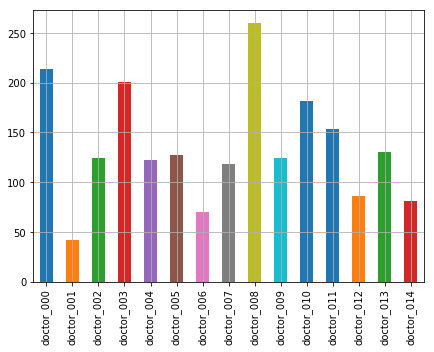

In [5]:
plt.figure(figsize=(7, 5))
ax = (
    nodules
    .set_index('AccessionNumber')
    .merge(annotators, left_index=True, right_index=True)
    .filter(regex='doctor_\d{3}', axis=1)
    .unstack()
    .groupby(level=0)
    .sum()
    .plot(kind='bar', grid=True)
)

You can use **assign_nodules_group_index** function to add column *GroupNoduleID* that contains the same values
for different overlapping nodules(commonly, that group of overlapping nodules is just annotations from different doctors):

**Note**: before assigning nodules group index and uniting them into group you need to check that **[coordX, coordY, coordZ]** columns contain coordintates in mm. If coordinates provided in pixel scale you can make the following transform:

In [6]:
dataset_info = (
    radio.annotation.read_dataset_info('/media/kirill/data/ct_scans/part_08/*/*/*/*/*', index_col=None)
    .drop_duplicates(subset=['AccessionNumber'])
    .set_index('AccessionNumber')
)

nodules = (
    radio.annotation.read_nodules('/media/kirill/data/ct_annotation/08_annotation.txt')
    .set_index('AccessionNumber')
    .assign(coordZ=lambda df: df.loc[:, 'coordZ'] * dataset_info.loc[df.index, 'SpacingZ'],
            coordY=lambda df: df.loc[:, 'coordY'] * dataset_info.loc[df.index, 'SpacingY'],
            coordX=lambda df: df.loc[:, 'coordX'] * dataset_info.loc[df.index, 'SpacingX'])
    .reset_index()
)

As you can see, additional information about spacing in dataset's scans is required to do that. It can be easily obtained using **radio.annotation.read_dataset_info** function.

In [7]:
from radio.annotation import assign_nodules_group_index

nodules_with_group_index = (
    nodules
    .set_index(['AccessionNumber', 'NoduleID'])
    .groupby(level=0)
    .apply(assign_nodules_group_index)
    .reset_index()
)

In [8]:
nodules_with_group_index.head()

,AccessionNumber,NoduleID,DoctorID,NoduleType,coordX,coordY,coordZ,diameter_mm,GroupNoduleID
0,AGFA000000061588,a001e3098903ae3f3779,002,solid,280.030,187.142,330.0,9.0,5b294861f327e53f5d79
1,AGFA000000061588,7a1ba45c3f45d53f54ad,002,semi_solid,98.352,242.465,221.0,5.0,aad16633eb79de3fc67b
2,AGFA000000061588,70bc04663c5fbb3f1f29,002,solid,111.329,103.816,134.0,5.0,fc18eeaf0ca8e43f48fc
3,AGFA000000061588,05ae56314e74e03f436b,002,semi_solid,108.597,110.646,133.0,4.0,c2bf2cea6a74e23f1908
4,AGFA000000061588,808e521d50c39f3f69a8,005,semi_solid,281.396,186.459,330.0,9.0,5b294861f327e53f5d79


Let's plot number of nodules with different numbers of verifications for each doctor. Number of verifications represents number of overlapping nodules in group: 

/home/kirill/anaconda3/envs/nn/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


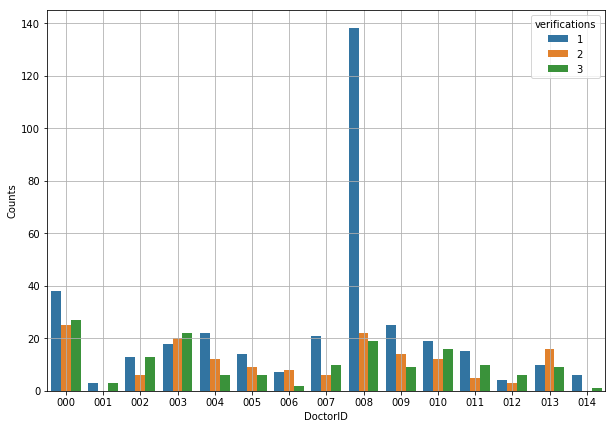

In [9]:
plt.figure(figsize=(7, 5))

data = (
    nodules_with_group_index
    .set_index('GroupNoduleID')
    .assign(verifications=lambda df: df.groupby(level=0).agg({'NoduleID': 'count'}))
    .groupby(['DoctorID', 'verifications'])
    .agg({'NoduleID': 'count'})
    .query('verifications <= 3')
    .reset_index()
)

plt.figure(figsize=(10, 7))
sns.barplot(x='DoctorID', y='NoduleID', hue='verifications', data=data)
plt.ylabel('Counts')
plt.grid(True)

## Gluing overlapping nodules together

Due to the fact that each cancer nodule can be annotated by several doctors we need to have a way to group overlapping nodules and then cover them with one big nodule. Generally, we also want to take into account different weights for different nodules. Function **glue_nodules** from **radio.annotation** will do this work for you. There are two conditions:
nodules dataframe must have confidence column that reflects the weight of nodule and **proba** parameter that is required for building normal-density approximation of covering nodule.

In [10]:
group_nodules = (
    radio.annotation.read_nodules(annotation_path)
    .set_index('AccessionNumber')
    .assign(coordZ=lambda df: df.loc[:, 'coordZ'] * dataset_info.loc[df.index, 'SpacingZ'],
            coordY=lambda df: df.loc[:, 'coordY'] * dataset_info.loc[df.index, 'SpacingY'],
            coordX=lambda df: df.loc[:, 'coordX'] * dataset_info.loc[df.index, 'SpacingX'])
    .reset_index()
    .assign(NoduleConfidence=1)
    .pipe(radio.annotation.get_nodules_groups, proba=0.8)
)

In [11]:
group_nodules.head()

,GroupNoduleID,AccessionNumber,NoduleConfidence,coordX,coordY,coordZ,diameter_mm
0,00161f6d27337f3ffd86,AGFA000000067606,1.0,275.210000,217.906000,137.0,35.000000
1,004483ca506be03f2605,AGFA000000065447,1.0,279.620000,147.994000,307.0,9.000000
2,00ade49105dab33f3a87,AGFA000000065450,1.0,152.750667,283.344667,97.5,5.094253
3,00c88604cbc8413fc2db,AGFA000000067187,1.0,111.329000,119.525000,206.0,5.000000
4,00d33572fa0d743f8018,AGFA000000070333,1.0,113.220000,259.000000,307.0,9.000000


Source annotation contained more nodules then dataframe with glued nodules:

In [12]:
nodules.shape[0], group_nodules.shape[0]

(678, 487)

Number of nodules reduced because we united overlapping nodules within the group into one nodule.

## Computing doctors and nodules confidences

In [13]:
from radio.annotation import get_doctors_confidences
from radio.annotation import compute_nodule_confidence

nodules_with_confidences = (
    radio.annotation.read_nodules(annotation_path)
    .set_index('AccessionNumber')
    .assign(coordZ=lambda df: df.loc[:, 'coordZ'] * dataset_info.loc[df.index, 'SpacingZ'],
            coordY=lambda df: df.loc[:, 'coordY'] * dataset_info.loc[df.index, 'SpacingY'],
            coordX=lambda df: df.loc[:, 'coordX'] * dataset_info.loc[df.index, 'SpacingX'])
    .merge(annotators, left_index=True, right_index=True)
    .reset_index()
    .pipe(get_doctors_confidences, smooth=4, n_iters=8)
    .pipe(compute_nodule_confidence, alpha=0.5, weight_by_doctor=False)
    .pipe(radio.annotation.get_nodules_groups, proba=0.8)
)

100%|██████████| 8/8 [00:21<00:00,  2.75s/it]


Let's have a look at distribution of nodules' confidence after min-max scaling:

In [18]:
import seaborn as sns

x = nodules_with_confidences.NoduleConfidence
nodules_with_confidences.NoduleConfidence = (x - x.min()) / (x.max() - x.min())

sns.distplot(nodules_with_confidences.loc[:, 'NoduleConfidence'], grid=True)

TypeError: distplot() got an unexpected keyword argument 'grid'

## Creating dicom dataset's FilesIndex and Dataset objects

In [13]:
from radio import dataset as ds
from radio.dataset import V, B, F

dataset_path = '/media/kirill/data/ct_scans/part_08/'
dataset_info = (
    radio.annotation.read_dataset_info(path='/media/kirill/data/ct_scans/part_08/*/*/*/*/*')
    .drop_duplicates(subset=['AccessionNumber'])
    .set_index('AccessionNumber')
)
ct_index = ds.FilesIndex(dataset_info.index.values, paths=dict(dataset_info.loc[:, 'ScanPath']), dirs=True)
ct_dataset = ds.Dataset(ct_index, batch_class=radio.CTImagesMaskedBatch)

Remember that input dataframe for **fetch_nodules_info** actions requires *seriesuid* column:

In [14]:
ct_nodules = (
    radio.annotation.read_nodules(annotation_path)
    .assign(seriesuid=lambda df: df.loc[:, 'AccessionNumber'])
)
ct_nodules.head()

,AccessionNumber,DoctorID,NoduleID,NoduleType,coordX,coordY,coordZ,diameter_mm,seriesuid
40,AGFA000000061588,002,14c4419196e7ea3f18c0,solid,410.0,274.0,330.0,9.0,AGFA000000061588
41,AGFA000000061588,002,5259b71fb095d63ffcba,semi_solid,144.0,355.0,221.0,5.0,AGFA000000061588
45,AGFA000000061588,002,804807d38498b73f5068,solid,163.0,152.0,134.0,5.0,AGFA000000061588
46,AGFA000000061588,002,28505d4d9679e53f31c9,semi_solid,159.0,162.0,133.0,4.0,AGFA000000061588
80,AGFA000000061588,005,cadfd11cac49d23f861c,semi_solid,412.0,273.0,330.0,9.0,AGFA000000061588


There is one major problem connected with annotation provided by radiologists: coordinates of nodules' centers are provided in pixel scale while diameter has 'mm' scale. If we simply put nodules as an argument of **fetch_nodules_info** function, we will get wrong masks. This could be avoided if both nodules' centers coordinates and diameter were provided in 'mm' scale. However in that case we would need to transform nodules dataframe using info about spacing and origin from all dataset. It is very expensive operation because fetching origin for all scans in dataset will require to read all CT scans in RAM. Fortunatelly, there is an alternative solution: transform coords 'on-the-fly' using F-named expression from dataset submodule in a combination with inverse transform using spacing and origin from batch:

In [15]:
def inverse_spacing_origin_transform(batch, nodules):
    """ Transform spacing and origin in nodules dataframe on fly. """
    indices = np.intersect1d(nodules.seriesuid.values, batch.indices)

    nodules = nodules.set_index('seriesuid')
    if len(indices) > 0:
        nodules = nodules.loc[indices, :]
        pos = batch.index.get_pos(nodules.index)

        nodules.loc[:, 'coordZ'] *= batch.spacing[pos, 0]
        nodules.loc[:, 'coordY'] *= batch.spacing[pos, 1]
        nodules.loc[:, 'coordX'] *= batch.spacing[pos, 2]

        nodules.loc[:, 'coordZ'] += batch.origin[pos, 0]
        nodules.loc[:, 'coordY'] += batch.origin[pos, 1]
        nodules.loc[:, 'coordX'] += batch.origin[pos, 2]

    return nodules.reset_index()

In [16]:
sample_nodules_ppl = ct_dataset >> (
    ds.Pipeline()
    .load(fmt='dicom')
    .fetch_nodules_info(nodules=F(inverse_spacing_origin_transform, nodules=ct_nodules))
    .unify_spacing(shape=(400, 512, 512), spacing=(1.7, 1.0, 1.0), method='pil-simd')
    .normalize_hu()
    .create_mask()
    .sample_nodules(nodule_size=(32, 64, 64), batch_size=None, share=1.0)
)

If we want to use **group_nodules** dataframe that was created earlier, we don't need to transform coordinates using inverse spacing transform: we have already done this before computation of overlapping groups. In that case only inverse origin transform must be applied. As an alternative to this we can just set origin to zeros after loading scans:

In [17]:
sample_nodules_ppl = ct_dataset >> (
    ds.Pipeline()
    .load(fmt='dicom')
    .load(fmt='ndarray', origin=F(lambda batch: np.zeros_like(batch.origin)))
    .fetch_nodules_info(nodules=group_nodules.assign(seriesuid=lambda df: df.loc[:, 'AccessionNumber']))
    .normalize_hu()
    .create_mask()
    .sample_nodules(nodule_size=(32, 64, 64), batch_size=None, share=1.0)
)

Let's generate batch with crops sampled from two scans:

In [18]:
batch = sample_nodules_ppl.next_batch(batch_size=2)

Now we can plot obtained nodules and visually verify built masks:

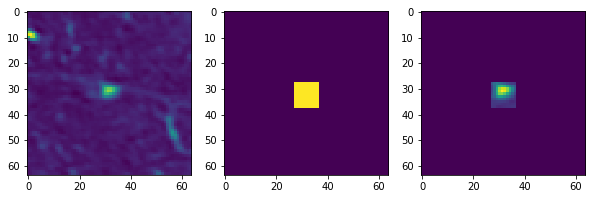

In [20]:
plt.figure(figsize=(10, 8))

image, mask = batch.get(2, 'images'), batch.get(2, 'masks')

ax_image = plt.subplot('131')
ax_image.imshow(image[16, :, :])

ax_mask = plt.subplot('132')
ax_mask.imshow(mask[16, :, :])

ax_mask_image = plt.subplot('133')
ax_mask_image.imshow(mask[16, :, :] * image[16, :, :])